In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from scipy.io import loadmat
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from scipy.sparse import csc_matrix, csr_matrix

np.set_printoptions(linewidth=1000)

Number of qubits: 3
Number of params: 64
Number of gates: 34
Loss: 0.571126988137046, Fidelity: 0.428873011862954,  10, 0.0118
Loss: 0.403754944216680, Fidelity: 0.596245055783320,  20, 0.0217
Loss: 0.328283741784540, Fidelity: 0.671716258215460,  30, 0.0322
Loss: 0.102896162669289, Fidelity: 0.897103837330711,  40, 0.0460
Loss: 0.005874934859461, Fidelity: 0.994125065140539,  50, 0.0607
Loss: 0.000025597050161, Fidelity: 0.999974402949839,  60, 0.0767
Loss: 0.000000431334372, Fidelity: 0.999999568665628,  70, 0.0896
Loss: 0.000000010078638, Fidelity: 0.999999989921362,  80, 0.1011
Converged (|f_n-f_(n-1)| ~= 0)
Optimal: 0.00000000092405771923
psi norm: 1.60894226518078142796
psi fidelity: 0.99999999953797114038


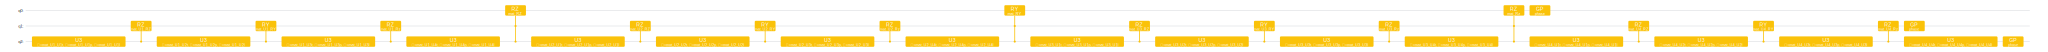

In [4]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


# Without reverse qubits
def universal_ansatz(gate: UnivMathGate):
    name = f'{gate.name}_'
    obj = gate.obj_qubits
    circ = Circuit()
    if len(obj) == 1:
        circ += RZ(f'{name}RZ').on(obj[0])
        circ += RY(f'{name}RY').on(obj[0])
        circ += RZ(f'{name}Rz').on(obj[0])
    elif len(obj) == 2:
        circ += U3(f'{name}U1t', f'{name}U1p', f'{name}U1l').on(obj[1])
        circ += RZ(f'{name}RZ').on(obj[0], obj[1])
        circ += U3(f'{name}U2t', f'{name}U2p', f'{name}U2l').on(obj[1])
        circ += RY(f'{name}RY').on(obj[0], obj[1])
        circ += U3(f'{name}U3t', f'{name}U3p', f'{name}U3l').on(obj[1])
        circ += RZ(f'{name}Rz').on(obj[0], obj[1])
        circ += U3(f'{name}U4t', f'{name}U4p', f'{name}U4l').on(obj[1])
    else:
        n = 2**len(obj[1:])
        circ += universal_ansatz(UnivMathGate(f'{name}U1', np.eye(n)).on(obj[1:]))
        circ += RZ(f'{name}RZ').on(obj[0], obj[1:])
        circ += universal_ansatz(UnivMathGate(f'{name}U2', np.eye(n)).on(obj[1:]))
        circ += RY(f'{name}RY').on(obj[0], obj[1:])
        circ += universal_ansatz(UnivMathGate(f'{name}U3', np.eye(n)).on(obj[1:]))
        circ += RZ(f'{name}Rz').on(obj[0], obj[1:])
        circ += universal_ansatz(UnivMathGate(f'{name}U4', np.eye(n)).on(obj[1:]))
    return circ


d, m = 2, 3
nq = (d - 1) * m
Id = su2_encoding(np.eye(d**m), m)
p = np.eye(Id.shape[0]) - Id

mat = unitary_group.rvs(d**m)
mat = su2_encoding(mat, m) + p
gate = UnivMathGate('mat', mat).on(list(range(nq)))

sim = Simulator('mqvector', nq)
sim.apply_gate(gate)
psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))

ansatz = universal_ansatz(gate)
for i in range(nq):
    ansatz += GlobalPhase(f'phase').on(i)
p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='TNC', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))

ansatz.svg()

Number of qubits: 3
Number of params: 64
Number of gates: 34
Loss: 0.842693137416978, Fidelity: 0.157306862583022,  10, 0.0053
Loss: 0.927963440874208, Fidelity: 0.072036559125792,  20, 0.0101
Loss: 0.717605384201936, Fidelity: 0.282394615798064,  30, 0.0190
Loss: 0.805996636246322, Fidelity: 0.194003363753678,  40, 0.0266
Loss: 0.515686435304204, Fidelity: 0.484313564695796,  50, 0.0350
Loss: 0.378132966341404, Fidelity: 0.621867033658596,  60, 0.0431
Loss: 0.034007268919533, Fidelity: 0.965992731080467,  70, 0.0502
Loss: 0.005365919715360, Fidelity: 0.994634080284640,  80, 0.0547
Loss: 0.000187643918850, Fidelity: 0.999812356081150,  90, 0.0595
Loss: 0.000000072815934, Fidelity: 0.999999927184066, 100, 0.0644
Loss: 0.000000013359706, Fidelity: 0.999999986640294, 110, 0.0687
Converged (|f_n-f_(n-1)| ~= 0)
Optimal: 0.00000000002268873978
psi norm: 0.23874761353079007598
psi fidelity: 0.99999999998865563011


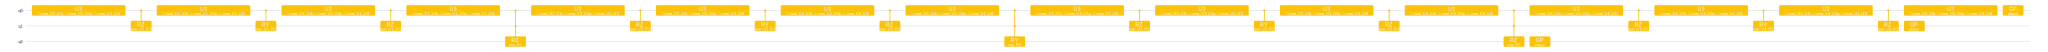

In [3]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


# With reverse qubits
def universal_ansatz(gate: UnivMathGate):
    name = f'{gate.name}_'
    obj = gate.obj_qubits
    circ = Circuit()
    if len(obj) == 1:
        circ += RZ(f'{name}RZ').on(obj[0])
        circ += RY(f'{name}RY').on(obj[0])
        circ += RZ(f'{name}Rz').on(obj[0])
    elif len(obj) == 2:
        circ += U3(f'{name}U1t', f'{name}U1p', f'{name}U1l').on(obj[0])
        circ += RZ(f'{name}RZ').on(obj[1], obj[0])
        circ += U3(f'{name}U2t', f'{name}U2p', f'{name}U2l').on(obj[0])
        circ += RY(f'{name}RY').on(obj[1], obj[0])
        circ += U3(f'{name}U3t', f'{name}U3p', f'{name}U3l').on(obj[0])
        circ += RZ(f'{name}Rz').on(obj[1], obj[0])
        circ += U3(f'{name}U4t', f'{name}U4p', f'{name}U4l').on(obj[0])
    else:
        n = 2**len(obj[1:])
        circ += universal_ansatz(UnivMathGate(f'{name}U1', np.eye(n)).on(obj[:-1]))
        circ += RZ(f'{name}RZ').on(obj[-1], obj[:-1])
        circ += universal_ansatz(UnivMathGate(f'{name}U2', np.eye(n)).on(obj[:-1]))
        circ += RY(f'{name}RY').on(obj[-1], obj[:-1])
        circ += universal_ansatz(UnivMathGate(f'{name}U3', np.eye(n)).on(obj[:-1]))
        circ += RZ(f'{name}Rz').on(obj[-1], obj[:-1])
        circ += universal_ansatz(UnivMathGate(f'{name}U4', np.eye(n)).on(obj[:-1]))
    return circ


d, m = 2, 3
nq = (d - 1) * m
Id = su2_encoding(np.eye(d**m), m)
p = np.eye(Id.shape[0]) - Id

mat = unitary_group.rvs(d**m)
mat = su2_encoding(mat, m) + p
gate = UnivMathGate('mat', mat).on(list(range(nq)))

sim = Simulator('mqvector', nq)
sim.apply_gate(gate)
psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))

ansatz = universal_ansatz(gate)
for i in range(nq):
    ansatz += GlobalPhase(f'phase').on(i)
p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='TNC', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))

ansatz.svg()

[[0.34880034+0.j         0.40977999-0.24334959j]
 [0.40977999+0.24334959j 0.65119966+0.j        ]] (1+0j)
[[-0.30155987-0.50780113j  0.70856123+0.38618732j]
 [ 0.69384473+0.41204265j  0.59059321+0.j        ]] (0.28903334387559976-0.5078011293587641j)
[0.53639729-0.17207415j 0.7502259 +0.17207415j]
[0.28779342-0.08599395j 0.90823478+0.29135815j]
[[-0.30155987-0.50780113j  0.70856123+0.38618732j]
 [ 0.69384473+0.41204265j  0.59059321+0.j        ]] (0.28903334387559976-0.5078011293587641j)


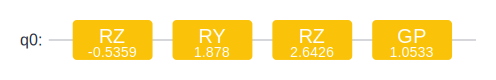

In [3]:
np.random.seed(42)
gate = np.random.rand(2) + 1j * np.random.rand(2)
gate /= norm(gate)
gate = np.outer(gate, gate.conj())
print(gate, np.trace(gate))
gate_u = UnivMathGate('gate', gate).on(0)
gate_d = euler_decompose(gate_u)
print(gate_d.matrix(), np.trace(gate_d.matrix()))

circ_u = Circuit() + gate_u
circ_d = Circuit() + gate_d
sim_u = Simulator('mqvector', 1)
sim_u.apply_gate(H(0))
sim_u.apply_circuit(circ_u)
print(sim_u.get_qs())
sim_d = Simulator('mqvector', 1)
sim_d.apply_gate(H(0))
sim_d.apply_circuit(circ_d)
print(sim_d.get_qs())
print(circ_d.matrix(), np.trace(circ_d.matrix()))

circ_d.svg()

[[ 0.27702459-0.13059069j -0.76350488+0.56856287j]
 [ 0.36122517+0.88074958j  0.1700831 +0.25469254j]]
[[ 0.27702459-0.13059069j -0.76350488+0.56856287j]
 [ 0.36122517+0.88074958j  0.1700831 +0.25469254j]]
[[1.+8.19750498e-17j 1.-9.35397789e-17j]
 [1.-1.07903856e-16j 1.-2.26100146e-16j]] True


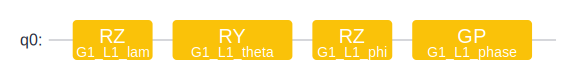

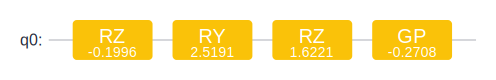

In [4]:
optional_basis = ['zyz', 'u3']
A = np.array([[1, 1, -1, 1], [1, 1, 1, -1], [1, -1, -1, -1], [1, -1, 1, 1]])
M = np.array([[1, 0, 0, 1j], [0, 1j, 1, 0], [0, 1j, -1, 0], [1, 0, 0, -1j]]) / np.sqrt(2)

def decompose_zyz(mat: np.array):
    d = mat.shape[0]
    if not np.allclose(np.eye(d), mat @ mat.conj().T):
        raise ValueError('The gate is not unitary')
    phase = -np.angle(det(mat)) / 2
    matU = mat * np.exp(1j * phase)
    cos = np.sqrt(np.real(matU[0][0] * matU[1][1]))
    theta = 2 * np.arccos(cos)
    phi = np.angle(matU[1][1]) + np.angle(matU[1][0])
    lam = np.angle(matU[1][1]) - np.angle(matU[1][0])
    return phase, theta, phi, lam


def decompose_u3(mat: np.array):
    phase, theta, phi, lam = decompose_zyz(mat)
    phase += (phi + lam) / 2
    return phase, theta, phi, lam


def one_qubit_decompose(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = True) -> Circuit:
    name_phase = gate.name + '_phase'
    name_theta = gate.name + '_theta'
    name_phi = gate.name + '_phi'
    name_lam = gate.name + '_lam'
    obj = gate.obj_qubits
    mat = gate.matrix()
    circ = Circuit()
    if basis == 'zyz':
        phase, theta, phi, lam = decompose_zyz(mat)
        circ += RZ(name_lam).on(obj)
        circ += RY(name_theta).on(obj)
        circ += RZ(name_phi).on(obj)
    elif basis == 'u3':
        circ += U3(name_theta, name_phi, name_lam).on(obj)
        phase, theta, phi, lam = decompose_u3(mat)
    else:
        raise ValueError(f'{basis} is not a supported decomposition method of {optional_basis}')
    if with_phase:
        circ += GlobalPhase(name_phase).on(obj)
    pr = {name_phase: phase, name_phi: phi, name_theta: theta, name_lam: lam}
    return circ, pr


d = 2
gate = unitary_group.rvs(d, random_state=42)
print(gate)
gate_u = UnivMathGate('G1_L1', gate).on(0)
gate_d, pr = one_qubit_decompose(gate_u, 'zyz')
gate_mat = gate_d.matrix(pr)
print(gate_mat)
print(gate / gate_mat, np.allclose(gate, gate_mat))
display_svg(gate_d.svg())
gate_d.apply_value(pr).svg()

[[1.-7.88783220e-16j 1.-2.71095144e-15j 1.+7.34196781e-16j 1.+1.41162534e-15j]
 [1.-3.68464155e-16j 1.+1.79843065e-15j 1.+4.48444575e-16j 1.+4.01352820e-15j]
 [1.-1.16685605e-15j 1.-1.92814839e-15j 1.-6.51256664e-16j 1.+4.97864060e-16j]
 [1.-2.42170142e-15j 1.-4.64618979e-16j 1.-1.71938386e-15j 1.+1.43234776e-15j]] True


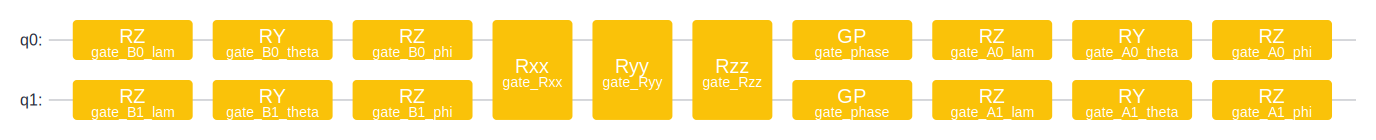

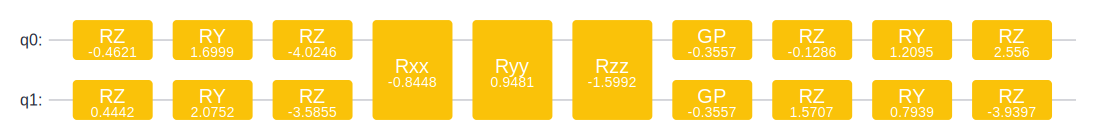

In [5]:
def simult_svd(mat1: np.ndarray, mat2: np.ndarray):
    d = mat1.shape[0]
    u_a, d_a, v_a_h = svd(mat1)
    u_a_h = u_a.conj().T
    v_a = v_a_h.conj().T
    if np.count_nonzero(d_a) != d:
        raise ValueError('Not implemented yet for the situation that mat1 is not full-rank')
    # g commutes with d
    g = u_a_h @ mat2 @ v_a
    # because g is hermitian, eigen-decomposition is its spectral decomposition
    _, p = eigh(g)  # p is unitary or orthogonal
    u = u_a @ p
    v = v_a @ p
    # ensure det(u_a) == det(v_a) == +1
    if det(u) < 0:
        u[:, 0] *= -1
    if det(v) < 0:
        v[:, 0] *= -1
    d1 = u.conj().T @ mat1 @ v
    d2 = u.conj().T @ mat2 @ v
    d = d1 + 1j * d2
    return u, v, d


def kron_factor_4x4_to_2x2s(mat: np.ndarray):
    # Use the entry with the largest magnitude as a reference point.
    a, b = max(((i, j) for i in range(4) for j in range(4)), key=lambda t: abs(mat[t]))
    # Extract sub-factors touching the reference cell.
    f1 = np.zeros((2, 2), dtype=CDTYPE)
    f2 = np.zeros((2, 2), dtype=CDTYPE)
    for i in range(2):
        for j in range(2):
            f1[(a >> 1) ^ i, (b >> 1) ^ j] = mat[a ^ (i << 1), b ^ (j << 1)]
            f2[(a & 1) ^ i, (b & 1) ^ j] = mat[a ^ i, b ^ j]
    # Rescale factors to have unit determinants.
    f1 /= np.sqrt(np.linalg.det(f1)) or 1
    f2 /= np.sqrt(np.linalg.det(f2)) or 1
    # Determine global phase.
    denominator = f1[a >> 1, b >> 1] * f2[a & 1, b & 1]
    if denominator == 0:
        raise ZeroDivisionError("denominator cannot be zero.")
    g = mat[a, b] / denominator
    if np.real(g) < 0:
        f1 *= -1
        g = -g
    return f1, f2


def two_qubit_decompose(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = True) -> Circuit:
    name_rxx = gate.name + '_Rxx'
    name_ryy = gate.name + '_Ryy'
    name_rzz = gate.name + '_Rzz'
    name_phase = gate.name + '_phase'
    obj0, obj1 = gate.obj_qubits
    mat = gate.matrix()
    circ = Circuit()
    circ_d = Circuit()
    ur = np.real(M.conj().T @ mat @ M)
    ui = np.imag(M.conj().T @ mat @ M)
    QL, QR, D = simult_svd(ur, ui)
    A1, A0 = kron_factor_4x4_to_2x2s(M @ QL @ M.conj().T)
    B1, B0 = kron_factor_4x4_to_2x2s(M @ QR.T @ M.conj().T)
    k = (A.T / 4) @ np.angle(np.diag(D))
    pr = {name_rxx: -2 * k[1], name_ryy: -2 * k[2], name_rzz: -2 * k[3], name_phase: k[0] / -2}
    circ += UnivMathGate(gate.name + '_B0', B0).on(obj0)
    circ += UnivMathGate(gate.name + '_B1', B1).on(obj1)
    circ += Rxx(name_rxx).on([obj0, obj1])
    circ += Ryy(name_ryy).on([obj0, obj1])
    circ += Rzz(name_rzz).on([obj0, obj1])
    circ += GlobalPhase(name_phase).on(obj0)
    circ += GlobalPhase(name_phase).on(obj1)
    circ += UnivMathGate(gate.name + '_A0', A0).on(obj0)
    circ += UnivMathGate(gate.name + '_A1', A1).on(obj1)
    for g in circ:
        if len(g.obj_qubits) == 1 and isinstance(g, UnivMathGate):
            if basis == 'zyz':
                gate_d, para = one_qubit_decompose(g, 'zyz', False)
            elif basis == 'u3':
                gate_d, para = one_qubit_decompose(g, 'u3')
            else:
                raise ValueError(f'{basis} is not a supported decomposition method of {optional_basis}')
            circ_d += gate_d
            pr.update(para)
        else:
            circ_d += g
    return circ_d, pr


d = 4
gate = unitary_group.rvs(d, random_state=42)
# print(gate)
gate_u = UnivMathGate('gate', gate).on([0, 1])
gate_d, pr = two_qubit_decompose(gate_u, 'zyz')
gate_mat = gate_d.matrix(pr)
# print(gate_mat)
print(gate / gate_mat, np.allclose(gate, gate_mat))
display_svg(gate_d.svg())
gate_d.apply_value(pr).svg()